Here we use value function iteration to solve the infinite horizon investment problem

The problem is 


$$v\left(k\right)= \max_{k'}k^\alpha + \left(1-\delta\right)k - k' - \frac{\theta}{2}\left(\frac{k'}{k} - \delta\right)^2 k + \frac{1}{1+r} v\left(k'\right)$$




In [1]:
using Plots 
using Parameters


In [2]:
Firm = @with_kw (r = 0.03,                 
                      α = 0.4,
                      A = 1,
                      δ = 0.05,
                      θ = 1,
                      k0 = 0.1,
                      f = k -> A * k^α,
                      adj_cost = (k,k′) ->  θ/2.0 * (k′/k - 1)^2.0 * k 
					  )

##NamedTuple_kw#291 (generic function with 2 methods)

In [3]:
firm   = Firm()

(r = 0.03, α = 0.4, A = 1, δ = 0.05, θ = 1, k0 = 0.1, f = var"#10#14"{Float64, Int64}(0.4, 1), adj_cost = var"#11#15"{Int64}(1))

In [4]:
function grid_vfi_infinite(N=1000,k_min=0.001,k_max=50)
# this function creates a grid
k_grid = collect(range(k_min, stop = k_max, length = N))
return k_grid
end

k_grid=grid_vfi_infinite();

In [5]:
function vfi_infinite(firm, k_grid; ϵ = 1e-6, maxiter = 1000)

# this is the key function here, it solves the firm's problem 
N      = length(k_grid);
V      = Matrix{Float64}(undef,N, 1);
V_old  = Matrix{Float64}(undef,N, 1);
K′     = Matrix{Float64}(undef,N, 1);
w_temp = Matrix{Float64}(undef,N, 1);
K′_ind = Matrix{Int}(undef, N, 1);


# guess something initial
V_old     .= firm.f.(k_grid)
err      = 10.0
# start iteration
for n in 1:maxiter
    
    # for each grid point today...
    for ik in eachindex(k_grid)
       
        #... consider each possible grid point tomorrow
        for ik′ in eachindex(k_grid)
            w_temp[ik′] = firm.f(k_grid[ik]) + (1.0 - firm.δ) * k_grid[ik] - k_grid[ik′] - firm.adj_cost(k_grid[ik],k_grid[ik′])  + 1.0 / (1.0 + firm.r) * V_old[ik′] # calulate utility + continuation value
        end

        V[ik], ik′_opt    = findmax(w_temp[:])  # find optimum - stores Value und policy (index of optimal choice)
		K′[ik]            = k_grid[ik′_opt]    # record optimal capital tomorrow
        K′_ind[ik]        = ik′_opt

    end
    
    err,z = findmax(abs.(V .- V_old));

    if err < ϵ
        break
    end

    V_old .= V 

end
return V, K′, K′_ind, err
end


vfi_infinite (generic function with 1 method)

In [7]:
# solve the problem for our firm
V, K′, K′_ind, err = vfi_infinite(firm, k_grid)

([49.63028374301448; 52.39583393409016; … ; 107.04230673101647; 107.08389558847317;;], [0.05104904904904905; 0.3012942942942943; … ; 41.341514514514515; 41.391563563563565;;], [2; 7; … ; 827; 828;;], 9.997284564633446e-7)

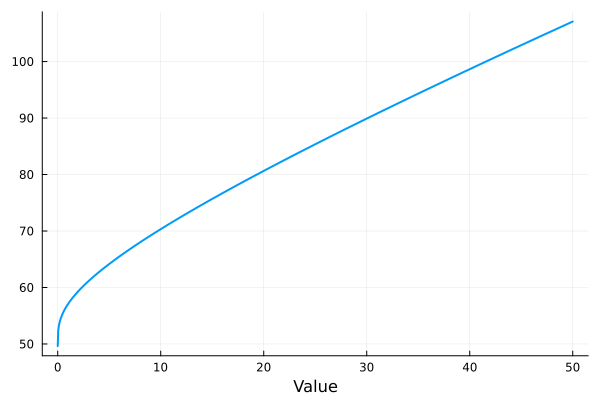

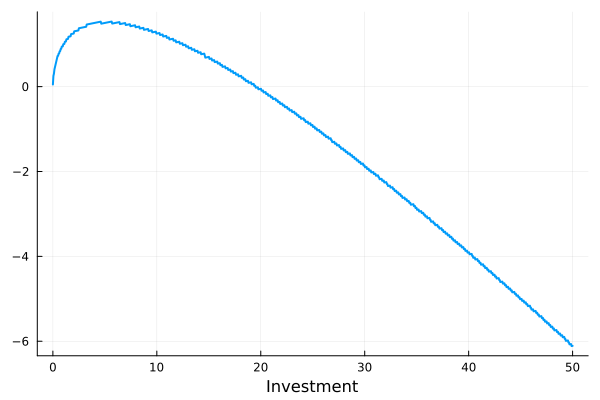

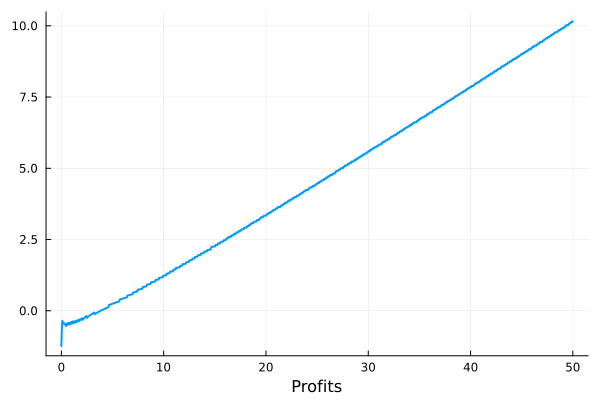

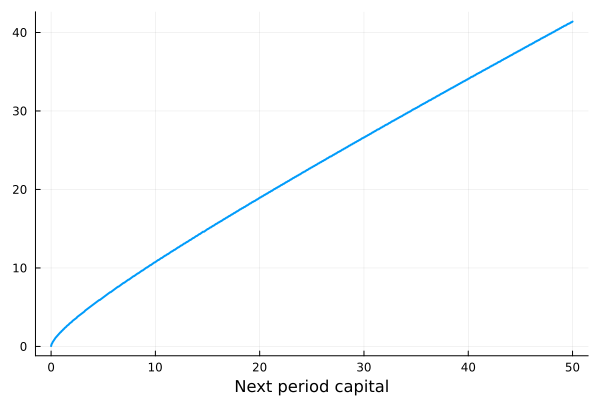

In [8]:


# plot the solution
value_plot        = plot(xlabel = "Value") 
investment_plot   = plot(xlabel = "Investment")
profit_plot       = plot(xlabel = "Profits")
nextcapital_plot       = plot(xlabel = "Next period capital")




plot!(profit_plot, k_grid, firm.f.(k_grid) .+ (1.0-firm.δ).*k_grid .- K′ .- firm.adj_cost.(k_grid,K′),labels=false, lw = 2)
plot!(investment_plot, k_grid, K′ .- (1.0-firm.δ).*k_grid,labels=false, lw = 2)
plot!(value_plot, k_grid,  V,labels=false, lw = 2)
plot!(nextcapital_plot, k_grid, K′,labels=false, lw = 2)

display(value_plot)
display(investment_plot)
display(profit_plot)
display(nextcapital_plot)

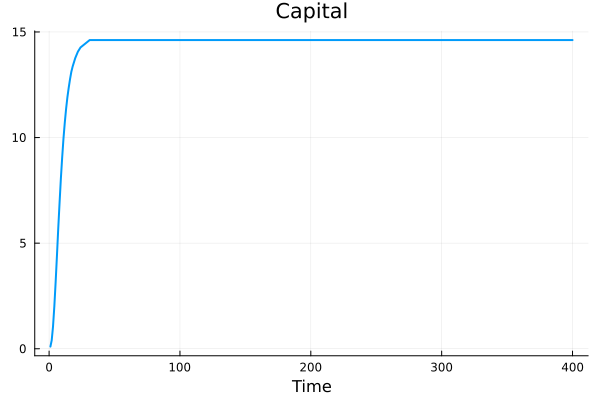

In [11]:


function get_paths(firm,K′,K′_ind,T)
# this function find the optimal paths
findnearest(A,x) = argmin(abs.(A .- x))

ik′ = findnearest(k_grid,firm.k0)
k_path = Array{Float64}(undef,T)
k′_path = Array{Float64}(undef,T)

for t = 1:T 
   ik         = ik′
   k_path[t]  = k_grid[ik] 
   k′_path[t] = K′[ik]  
   ik′        = K′_ind[ik]
end

return k_path, k′_path
end


# get those paths and plot them
T = 400
k_path, k′_path = get_paths(firm,K′,K′_ind,T)

capital_path_plot = plot(1:T,k_path,label=false, lw = 2, title = "Capital", xlabel = "Time")


display(plot(capital_path_plot))